# Tutorial 10 - Class Imbalance & k-Means

**Semester:** Winter 2025

**Adapted by:** [Kevin Dick](https://kevindick.ai/), [Igor Bogdanov](mailto:igorbogdanov@cmail.carleton.ca)

**Part I adapted from:** [Scikit-Learn's Plot Classifier Performance](https://scikit-learn.org/0.15/auto_examples/plot_classifier_comparison.html).

**Part II adapted from:** Andrew Yue Xie's [K-Means Clustering Implementation in Python](https://www.kaggle.com/andyxie/k-means-clustering-implementation-in-python)

---



## 1. Introduction
In this notebook, we will explore four different classifiers and how they perform on artificial datasets with linear and nonlinear class distributions, as the class imbalance changes from 1:1 to 1:100. We are most interested in how the decision boundaries change between various classifiers. We will then explore under-sampling as a way to solve the issue.

<i>Note that this Notebook is based on https://scikit-learn.org/0.15/auto_examples/plot_classifier_comparison.html</i>

The classifiers we will be looking at are:
- Logistic regression
- Decision tree
- linear SVM
- SVM with a nonlinear kernel
- K-Nearest-Neighbour <i>(yes, neighbour has a 'u'...)</i>

Scikit-learn has a powerful toolboxes for building classifiers, creating artificial data, and visualizing decision boundaries. The toolboxes can be seen in the import calls below.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb

We import these packages, but as usual we will also need numpy and matplotlib. Let's import those packages now.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## 2. The Data

Generate datasets with 1:1 class imbalance. Increase this to 1:10 and 1:100.


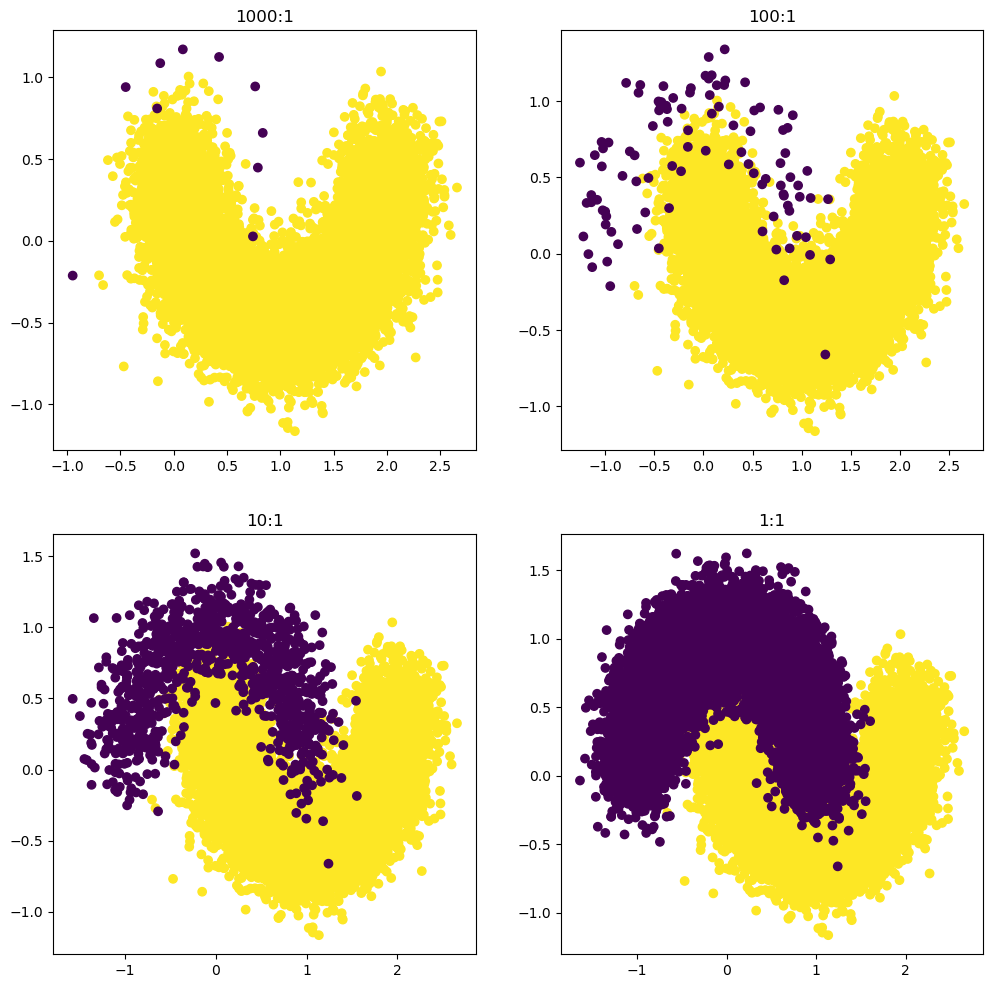

In [4]:
# Create 4 datasets of varying class imbalance:

# 1) Dataset where classes are distributed in moons
allX, ally = make_moons(noise=0.2, random_state=1, n_samples=20000)
allX_1 = allX[ally==1]
allX_0 = allX[ally==0]
ally_1 = ally[ally==1]
ally_0 = ally[ally==0]

numClass0 = 10 #1000:1
X1000 = np.concatenate((allX_1,allX_0[:numClass0,:]),axis=0) 
y1000 = np.concatenate((ally_1, ally_0[:numClass0]),axis=0)

numClass0 = 100 #100:1
X100 = np.concatenate((allX_1,allX_0[:numClass0,:]),axis=0) 
y100 = np.concatenate((ally_1, ally_0[:numClass0]),axis=0)

numClass0 = 1000 #10:1
X10 = np.concatenate((allX_1,allX_0[:numClass0,:]),axis=0) 
y10 = np.concatenate((ally_1, ally_0[:numClass0]),axis=0)

numClass0 = 10000 #1:1
X1 = np.concatenate((allX_1,allX_0[:numClass0,:]),axis=0) 
y1 = np.concatenate((ally_1, ally_0[:numClass0]),axis=0)

# Gather all four datasets
datasets = [(X1000,y1000),
            (X100,y100),
            (X10,y10),
            (X1,y1)]

dataset_names= ["1000:1", "100:1", "10:1", "1:1"]

## Visualize the datasets

#Plot 1000:1 data
plt.figure(figsize= (12,12))
plt.subplot(2, 2, 1)
plt.scatter(X1000[0:,0], X1000[0:,1], c=y1000)
plt.title(dataset_names[0])

#Plot Circles data
plt.subplot(2, 2, 2)
plt.scatter(X100[0:,0], X100[0:,1], c=y100)
plt.title(dataset_names[1])

#Plot Linearly separable
plt.subplot(2, 2, 3)
plt.scatter(X10[0:,0], X10[0:,1], c=y10)
plt.title(dataset_names[2])

#Plot Linearly separable
plt.subplot(2, 2, 4)
plt.scatter(X1[0:,0], X1[0:,1], c=y1)
plt.title(dataset_names[3]);  #(adding semi-colon suppresses output of text "Noisy Linearly Separable")

We've had a look at the data, now let's prepare our classifiers so that we can later evaluate how they perform on each dataset.

In [5]:
classifierNames = ["Logistic Regression", "Decision Tree", "Linear SVM", "RBF SVM","KNN"]

classifiers = [
    LogisticRegression(solver='lbfgs'), #Logistic regression
    DecisionTreeClassifier(max_depth=5), #Decision tree classifier with max_depth=5
    SVC(kernel="linear", C=0.025), #Linear SVM classifier
    SVC(kernel= 'rbf', gamma=2, C=1.0), # SVM with radial basis function kernel, gamma is kernel coefficient, C is penalty parameter for misclassified points
    KNeighborsClassifier(3)]

## 3. Classifier Performance

In this section, we will visualize the decision boundary for each classifier and compute the accuracy for each classifier on each dataset. We will follow the same training and testing protocol as in the CarsRegression notebook. 

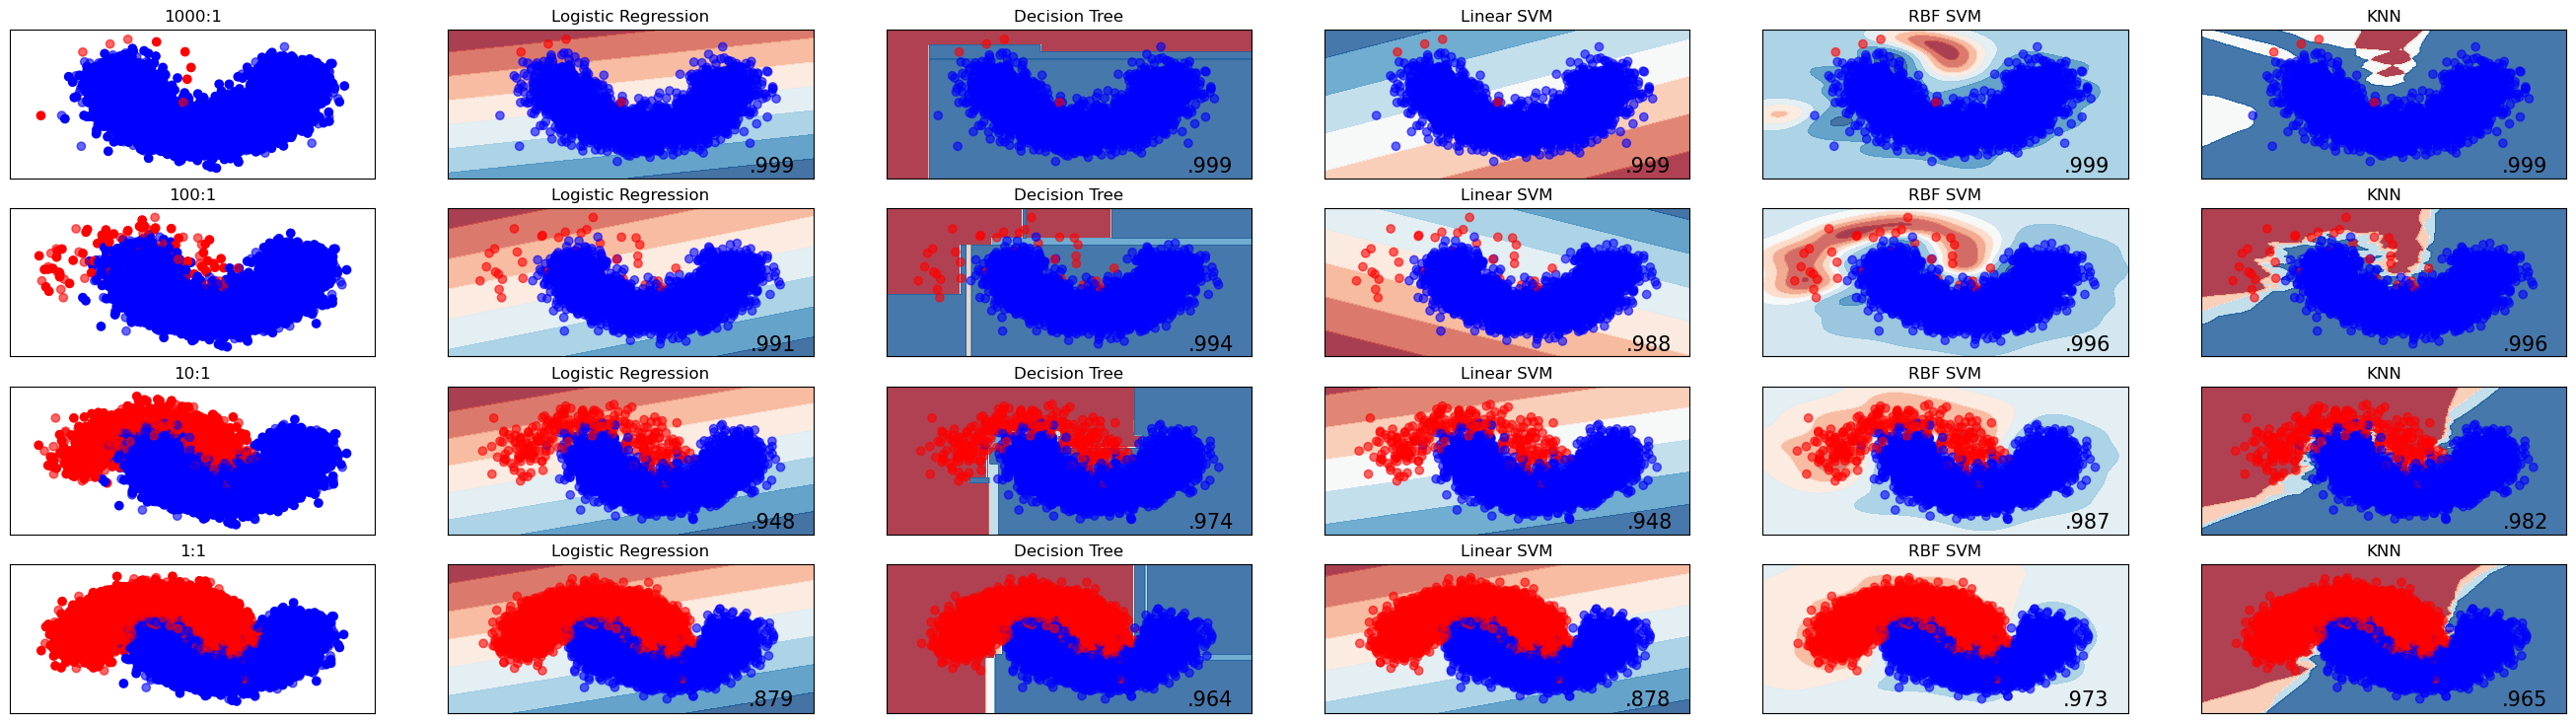

In [6]:
from sklearn.metrics import classification_report

h = .02  # Resolution in colored mesh visualizations
i= 1
figure = plt.figure(figsize=(27, 9))
j= 0


for ds in datasets:
    
    # Preprocess dataset, split into training and test part
    X, y = ds # X is feature vectors, y is class labels
    X = StandardScaler().fit_transform(X) # Standardize features by removing the mean and scaling to unit variance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) # handy function
    
    # Set plot axis limits
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    # Prepare some nice visualizations
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the datasets in first column
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i, title=dataset_names[j])
    j+= 1
    # Plot the training points 
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    # Iterate over classifiers ('zip' iterates through two equal-length lists simultaneously)
    for name, clf in zip(classifierNames, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        
        # Train and test our classifier
        clf.fit(X_train, y_train) # create classification model using training data
        score = clf.score(X_test, y_test) # evaluate classifier on the testing set

        # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            # flatten xx and yy to 1D arrays and get decision function, or decision boundary hyperplane
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) 
        else:
            # if no decision function available, use prediction probability as contrast for contour lines
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] 

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        #ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        
        # Plot the testing points (use alpha=0.6 to make them slightly transparent)
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        # Set axes limits
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        # Add a title and overlay the prediction score onto the bottom-right corner of the plot
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

In [23]:
from sklearn.metrics import classification_report
j= 0

for ds in datasets:
    
    # Preprocess dataset, split into training and test part
    X, y = ds # X is feature vectors, y is class labels
    X = StandardScaler().fit_transform(X) # Standardize features by removing the mean and scaling to unit variance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) # handy function
    
    # Look at Logistic Regression:
    name = classifierNames[0]
    clf = classifiers[0]

    # Train and test our classifier
    clf.fit(X_train, y_train) # create classification model using training data
    i += 1

    # Accuracy on the plot is not telling the whole story. Print classification report
    y_pred = clf.predict(X_test)
    target_names = ['red', 'blue']
    print(dataset_names[j])
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    j+=1


1000:1
              precision    recall  f1-score   support

         red       0.00      0.00      0.00         2
        blue       1.00      1.00      1.00      3001

    accuracy                           1.00      3003
   macro avg       0.50      0.50      0.50      3003
weighted avg       1.00      1.00      1.00      3003

100:1
              precision    recall  f1-score   support

         red       1.00      0.28      0.44        32
        blue       0.99      1.00      1.00      2998

    accuracy                           0.99      3030
   macro avg       1.00      0.64      0.72      3030
weighted avg       0.99      0.99      0.99      3030

10:1
              precision    recall  f1-score   support

         red       0.82      0.61      0.70       305
        blue       0.96      0.99      0.97      2995

    accuracy                           0.95      3300
   macro avg       0.89      0.80      0.84      3300
weighted avg       0.95      0.95      0.95      3300

1

code modified from: https://scikit-learn.org/0.15/auto_examples/plot_classifier_comparison.html

## 4. Discussion

- What did the full classification report show that the accuracy in the plots did not? 
- How would you address the class imbalance?

## 5. Try Subsampling of Majority (blue) Class to Achieve "Balanced Training Set"

In [24]:
# Try subsampling from the dominant class to achieve 1:1 balance in training only

from sklearn.metrics import classification_report
j= 0

for ds in datasets:
    
    # Preprocess dataset, split into training and test part
    X, y = ds # X is feature vectors, y is class labels
    X = StandardScaler().fit_transform(X) # Standardize features by removing the mean and scaling to unit variance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) # handy function
    
    # Apply subsampling:
    X_train_1 = X_train[y_train==1]
    X_train_0 = X_train[y_train==0]
    y_train_1 = y_train[y_train==1]
    y_train_0 = y_train[y_train==0]
    numClass0 = len(X_train)-sum(y_train)
    imbalance = len(X_train_1)/len(X_train_0)
    print("For dataset {0:d}, numClass0={1:d}, imbalance={2:.1f}".format(j,numClass0,round(imbalance)))
    X_train_SS = np.concatenate((X_train_0,X_train_1[:numClass0,:]),axis=0) 
    y_train_SS = np.concatenate((y_train_0, y_train_1[:numClass0]),axis=0) 

    ### Really should shuffle the dataset since it is now organized by classID...
    assert len(X_train_SS) == len(y_train_SS)
    p = np.random.permutation(len(X_train_SS))
    X_train_SS =  X_train_SS[p]
    y_train_SS = y_train_SS[p]
    print(f'Num in Subsampled: {len(X_train_SS)}')

    # Look at Logistic Regression:
    name = classifierNames[0]
    clf = classifiers[0]

    # Train and test our classifier
    clf.fit(X_train_SS, y_train_SS) # create classification model using training data

    # Print classification report
    y_pred = clf.predict(X_test)
    target_names = ['red', 'blue']
    print(dataset_names[j])
    print(classification_report(y_test, y_pred, target_names=target_names))
    j+=1


For dataset 0, numClass0=7, imbalance=1000.0
Num in Subsampled: 14
1000:1
              precision    recall  f1-score   support

         red       0.01      0.67      0.01         3
        blue       1.00      0.89      0.94      3000

    accuracy                           0.89      3003
   macro avg       0.50      0.78      0.48      3003
weighted avg       1.00      0.89      0.94      3003

For dataset 1, numClass0=68, imbalance=103.0
Num in Subsampled: 136
100:1
              precision    recall  f1-score   support

         red       0.06      0.88      0.12        32
        blue       1.00      0.86      0.92      2998

    accuracy                           0.86      3030
   macro avg       0.53      0.87      0.52      3030
weighted avg       0.99      0.86      0.92      3030

For dataset 2, numClass0=710, imbalance=10.0
Num in Subsampled: 1420
10:1
              precision    recall  f1-score   support

         red       0.39      0.87      0.54       290
        blue   

##6. Try Over-sampling the Rare (red) Class to Achieve a "Balanced Training Set"

In [25]:
# Try over-sampling from the rare class (red) to achieve 1:1 balance in training only

from sklearn.metrics import classification_report
j= 0

for ds in datasets:
    
    # Preprocess dataset, split into training and test part
    X, y = ds # X is feature vectors, y is class labels
    X = StandardScaler().fit_transform(X) # Standardize features by removing the mean and scaling to unit variance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) # handy function
    
    # Apply subsampling:
    X_train_1 = X_train[y_train==1]
    X_train_0 = X_train[y_train==0]
    y_train_1 = y_train[y_train==1]
    y_train_0 = y_train[y_train==0]
    numClass0 = len(X_train)-sum(y_train)
    imbalance = len(X_train_1)/len(X_train_0)
    print("For dataset {0:d}, numClass0={1:d}, imbalance={2:.1f}".format(j,numClass0,round(imbalance)))

    # To over-sample, add 'imbalance' copies of class 0 data:
    X_train_OS = X_train_1 
    y_train_OS = y_train_1 
    for k in range(round(imbalance)):
      X_train_OS = np.concatenate((X_train_OS,X_train_0),axis=0) 
      y_train_OS = np.concatenate((y_train_OS,y_train_0),axis=0) 
      print(f'Num in Oversampled: {len(X_train_OS)}')

    ### Really should shuffle the dataset since it is now organized by classID...
    assert len(X_train_OS) == len(y_train_OS)
    p = np.random.permutation(len(X_train_OS))
    X_train_OS =  X_train_OS[p]
    y_train_OS = y_train_OS[p]

    # Look at Logistic Regression:
    name = classifierNames[0]
    clf = classifiers[0]

    # Train and test our classifier
    clf.fit(X_train_OS, y_train_OS) # create classification model using training data

    # Print classification report
    y_pred = clf.predict(X_test)
    target_names = ['red', 'blue']
    print(dataset_names[j])
    print(classification_report(y_test, y_pred, target_names=target_names))
    j+=1


For dataset 0, numClass0=8, imbalance=875.0
Num in Oversampled: 7007
Num in Oversampled: 7015
Num in Oversampled: 7023
Num in Oversampled: 7031
Num in Oversampled: 7039
Num in Oversampled: 7047
Num in Oversampled: 7055
Num in Oversampled: 7063
Num in Oversampled: 7071
Num in Oversampled: 7079
Num in Oversampled: 7087
Num in Oversampled: 7095
Num in Oversampled: 7103
Num in Oversampled: 7111
Num in Oversampled: 7119
Num in Oversampled: 7127
Num in Oversampled: 7135
Num in Oversampled: 7143
Num in Oversampled: 7151
Num in Oversampled: 7159
Num in Oversampled: 7167
Num in Oversampled: 7175
Num in Oversampled: 7183
Num in Oversampled: 7191
Num in Oversampled: 7199
Num in Oversampled: 7207
Num in Oversampled: 7215
Num in Oversampled: 7223
Num in Oversampled: 7231
Num in Oversampled: 7239
Num in Oversampled: 7247
Num in Oversampled: 7255
Num in Oversampled: 7263
Num in Oversampled: 7271
Num in Oversampled: 7279
Num in Oversampled: 7287
Num in Oversampled: 7295
Num in Oversampled: 7303
Num in

## Discussion 2
- Which was more successful, under- or over-sampling?
- What other ways could you combat class imbalance?
- Which performance metrics would you use?

---

### Bonus: Synthetic Minority Oversampling Technique (SMOTE)

SMOTE-variants



In [26]:
!pip install smote-variants --no-deps


2025-04-03 13:58:10,352:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2025-04-03 13:58:10,353:INFO:MulticlassOversampling: Sampling minority class with label: 0
2025-04-03 13:58:10,354:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'distance_SMOTE'}")
2025-04-03 13:58:10,356:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-04-03 13:58:10,359:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2025-04-03 13:58:10,370:INFO:distance_SMOTE: simplex sampling with n_dim 2
2025-04-03 13:58:10,379:INFO:MulticlassOversampling: Sampling minority class with label: 2
2025-04-03 13:58:10,382:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2

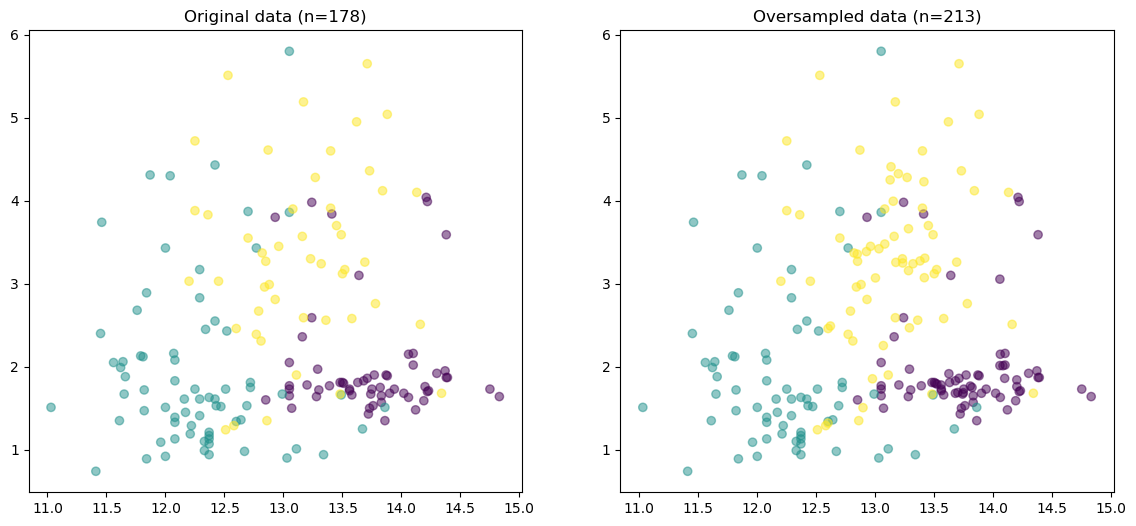

In [28]:
import matplotlib.pyplot as plt
import smote_variants as sv
from sklearn.datasets import load_wine

wine_bunch = load_wine()
X, y = wine_bunch['data'], wine_bunch['target']

oversampler = sv.MulticlassOversampling('distance_SMOTE')
X_samp, y_samp = oversampler.sample(X, y)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original data
ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.5)
ax[0].set_title(f'Original data (n={len(X)})')

# Oversampled data
ax[1].scatter(X_samp[:, 0], X_samp[:, 1], c=y_samp, cmap='viridis', alpha=0.5)
ax[1].set_title(f'Oversampled data (n={len(X_samp)})')

plt.show()

Text(0.5, 1.0, 'num total: 178')

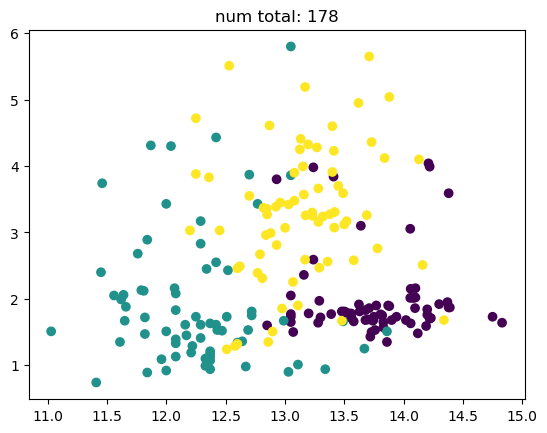

In [29]:
plt.scatter(X_samp[:,0], X_samp[:,1], alpha=1, c=y_samp, cmap='viridis')
plt.title(f'num total: {len(X)}')

### Excitingly: There are a tremendous number of techniques available!

The implemented techniques: [SMOTE] , [SMOTE_TomekLinks] , [SMOTE_ENN] , [Borderline_SMOTE1] , [Borderline_SMOTE2] , [ADASYN] , [AHC] , [LLE_SMOTE] , [distance_SMOTE] , [SMMO] , [polynom_fit_SMOTE] , [Stefanowski] , [ADOMS] , [Safe_Level_SMOTE] , [MSMOTE] , [DE_oversampling] , [SMOBD] , [SUNDO] , [MSYN] , [SVM_balance] , [TRIM_SMOTE] , [SMOTE_RSB] , [ProWSyn] , [SL_graph_SMOTE] , [NRSBoundary_SMOTE] , [LVQ_SMOTE] , [SOI_CJ] , [ROSE] , [SMOTE_OUT] , [SMOTE_Cosine] , [Selected_SMOTE] , [LN_SMOTE] , [MWMOTE] , [PDFOS] , [IPADE_ID] , [RWO_sampling] , [NEATER] , [DEAGO] , [Gazzah] , [MCT] , [ADG] , [SMOTE_IPF] , [KernelADASYN] , [MOT2LD] , [V_SYNTH] , [OUPS] , [SMOTE_D] , [SMOTE_PSO] , [CURE_SMOTE] , [SOMO] , [ISOMAP_Hybrid] , [CE_SMOTE] , [Edge_Det_SMOTE] , [CBSO] , [E_SMOTE] , [DBSMOTE] , [ASMOBD] , [Assembled_SMOTE] , [SDSMOTE] , [DSMOTE] , [G_SMOTE] , [NT_SMOTE] , [Lee] , [SPY] , [SMOTE_PSOBAT] , [MDO] , [Random_SMOTE] , [ISMOTE] , [VIS_RST] , [GASMOTE] , [A_SUWO] , [SMOTE_FRST_2T] , [AND_SMOTE] , [NRAS] , [AMSCO] , [SSO] , [NDO_sampling] , [DSRBF] , [Gaussian_SMOTE] , [kmeans_SMOTE] , [Supervised_SMOTE] , [SN_SMOTE] , [CCR] , [ANS] , [cluster_SMOTE]


---

## Part II: k-Means Implementation in Python



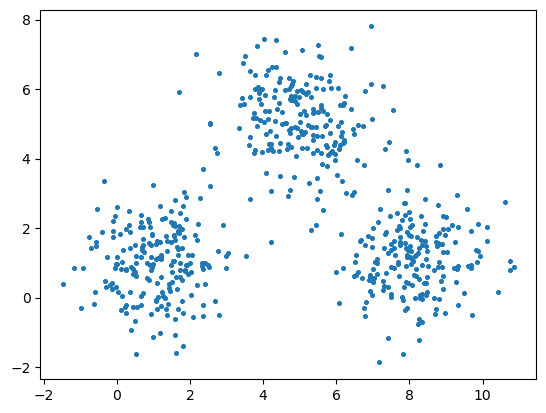

In [30]:
# Import necessary libraries
from copy import deepcopy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Set three centers, the model should predict similar results
center_1 = np.array([1,1])
center_2 = np.array([5,5])
center_3 = np.array([8,1])

# Generate random data and center it to the three centers
data_1 = np.random.randn(200, 2) + center_1
data_2 = np.random.randn(200,2) + center_2
data_3 = np.random.randn(200,2) + center_3

data = np.concatenate((data_1, data_2, data_3), axis = 0)

plt.scatter(data[:,0], data[:,1], s=7)
plt.show()

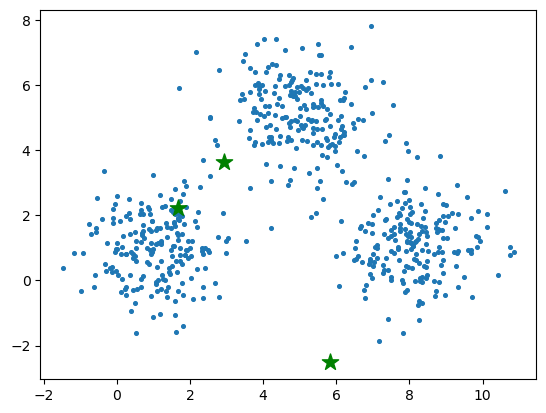

In [31]:
# Number of clusters
k = 3
# Number of training data
n = data.shape[0]
# Number of features in the data
c = data.shape[1]

# Generate random centers, here we use sigma and mean to ensure it represent the whole data
mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)
centers = np.random.randn(k,c)*std + mean

# Plot the data and the centers generated as random
plt.scatter(data[:,0], data[:,1], s=7)
plt.scatter(centers[:,0], centers[:,1], marker='*', c='g', s=150)
plt.show()

array([[1.06672678, 0.99024231],
       [5.22516859, 4.85339104],
       [8.18435997, 0.92511065]])

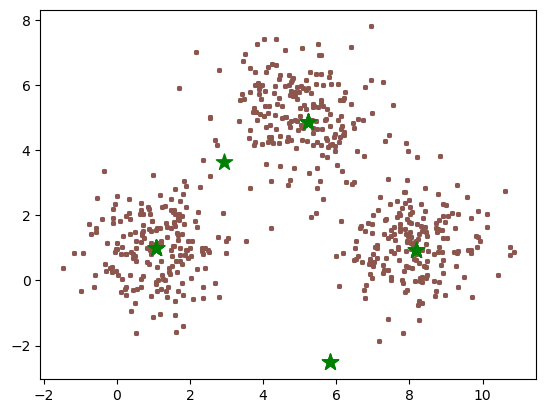

In [32]:
centers_old = np.zeros(centers.shape) # to store old centers
centers_new = deepcopy(centers) # Store new centers

data.shape
clusters = np.zeros(n)
distances = np.zeros((n,k))

error = np.linalg.norm(centers_new - centers_old)

# When, after an update, the estimate of that center stays the same, exit loop
while error != 0:
    # Measure the distance to every center
    for i in range(k):
        distances[:,i] = np.linalg.norm(data - centers[i], axis=1)
    # Assign all training data to closest center
    clusters = np.argmin(distances, axis = 1)
    
    centers_old = deepcopy(centers_new)
    # Calculate mean for every cluster and update the center
    for i in range(k):
        centers_new[i] = np.mean(data[clusters == i], axis=0)
        clear_output
        plt.scatter(data[:,0], data[:,1], s=7)
        plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)
    error = np.linalg.norm(centers_new - centers_old)
centers_new    

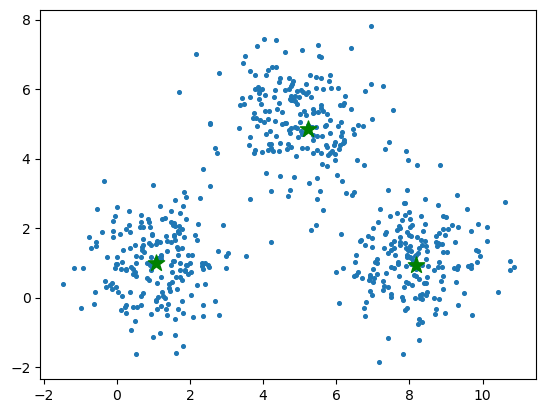

In [33]:
# Plot the data and the centers generated as random
plt.scatter(data[:,0], data[:,1], s=7)
plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)
plt.show()

#FIN